In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


In [2]:
df = pd.read_csv(r"C:\Users\WIN 10\Downloads\daily Charleston 1921-2014.csv")

In [3]:
# drop data in first line because its not technically data that we need
df.drop([0], inplace=True)
df.drop(columns=['depth', 'latitude', 'longitude', 'sensor_type_code'], inplace=True)

# change data types
df['time'] = pd.to_datetime(df['time'])
df['sea_surface_height_above_reference_level'] = pd.to_numeric(df['sea_surface_height_above_reference_level'])
df.dtypes

time                                        datetime64[ns, UTC]
sea_surface_height_above_reference_level                float64
dtype: object

In [4]:
# check missing value and percentage
df_notna = pd.DataFrame(df.notna().sum()).rename(columns={0:'notna'}).reset_index()
df_isna = pd.DataFrame(df.isna().sum()).rename(columns={0:'isna'}).reset_index()
df_isna_perc = df_notna.merge(df_isna, on='index', how='inner')
df_isna_perc['isna_percentage'] = df_isna_perc['isna']/(df_isna_perc['isna']+df_isna_perc['notna'])*100
df_isna_perc.sort_values('isna_percentage',ascending=False).head()

,index,notna,isna,isna_percentage
1,sea_surface_height_above_reference_level,33529,804,2.34177
0,time,34333,0,0.00000


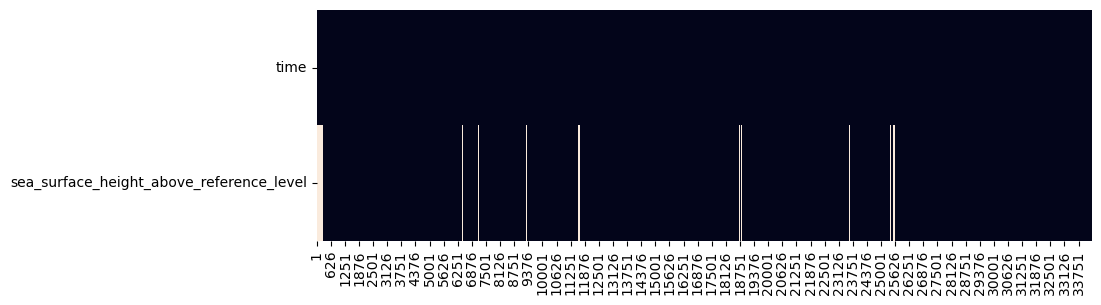

In [5]:
# Check missing value location in the data
plt.figure(figsize=(10, 3))
_ = sns.heatmap(df.isnull().T, cbar=False) #transpose the data so its easier to see

In [6]:
def plot_dataset_trendline(df, title, label='value'):
    plt.figure(figsize=(15, 5))
    # plot dataset
    sns.lineplot(x=df.index, y=df.value, label=label)

    # plot trendline (have to be clean from missing data)
    x = range(0, len(df))
    z = np.polyfit(x, y=df.value, deg=1)  
    p = np.poly1d(z)
    plt.plot(df.index, p(x), c="r", ls='-')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Sea Level (mm)')
    print(f'Total Sea level rise: {round(p(len(df)) - p(0), 2)} mm')


Total Sea level rise: 297.52 mm


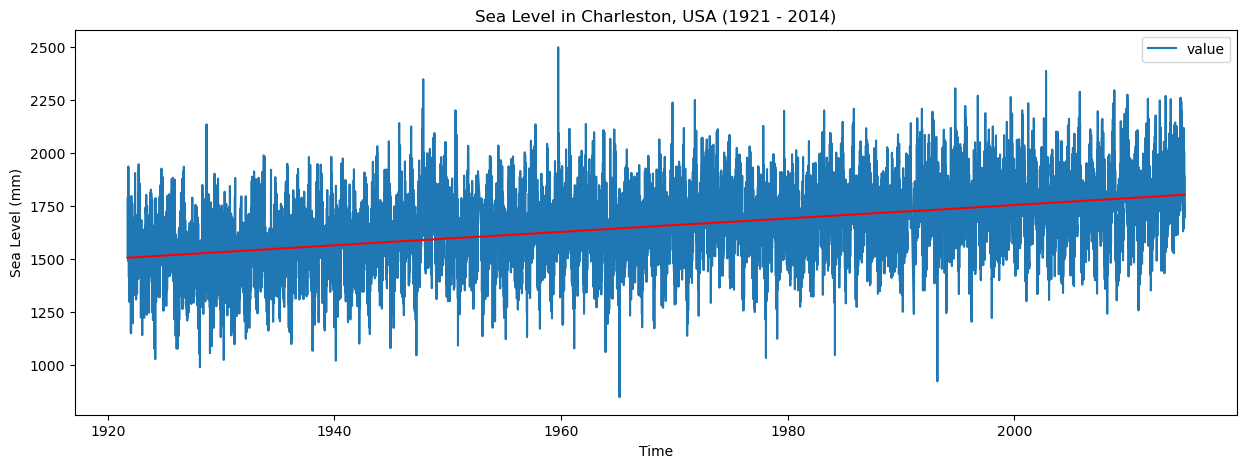

In [7]:
# make a new dataset for plotting (because we need to drop some missing values)
df_plot = df.dropna()
df_plot['year'] = df_plot['time'].dt.year
df_plot = df_plot.set_index(['time'])
df_plot = df_plot.rename(columns={'sea_surface_height_above_reference_level': 'value'})

# plot all of the dataset from 1921 - 2014
plot_dataset_trendline(df_plot, 'Sea Level in Charleston, USA (1921 - 2014)')

Total Sea level rise: 74.2 mm


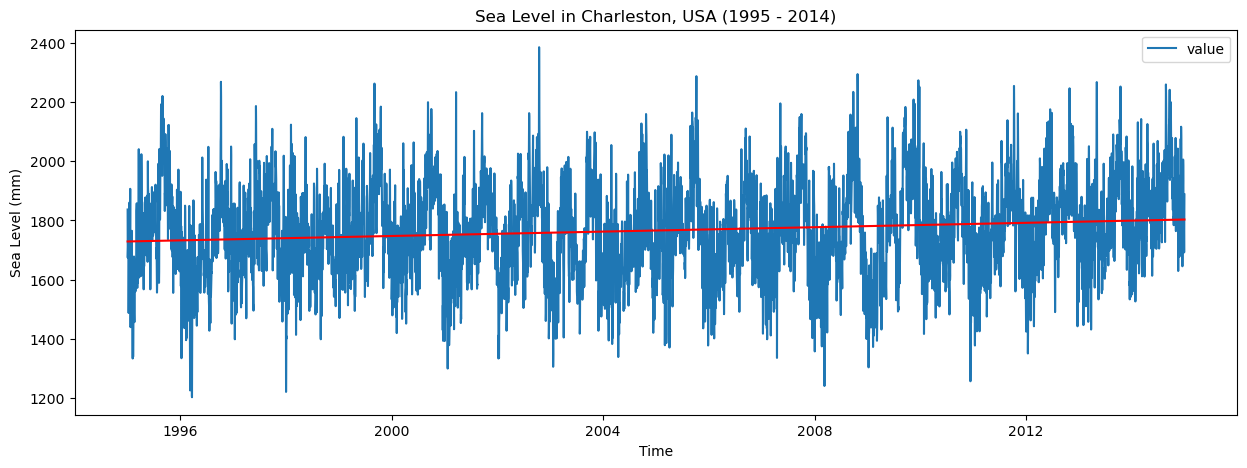

In [8]:
# plot latest 20 year of the dataset
plot_dataset_trendline(df_plot[df_plot['year'] > 1994], 'Sea Level in Charleston, USA (1995 - 2014)')

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_plot2 = df_plot.resample('M').mean()
df_plot2.reset_index(inplace= True)
df_plot2['time'] = df_plot2['time'].dt.to_period('M')
df_plot2 = df_plot2.set_index('time')
df_plot2.interpolate(inplace = True)
df_plot2.index = df_plot2.index.to_timestamp()
df_plot2.head()


,value,year
time,,
1921-10-01,1669.533333,1921.0
1921-11-01,1573.766667,1921.0
1921-12-01,1533.225806,1921.0
1922-01-01,1421.516129,1922.0
1922-02-01,1478.607143,1922.0


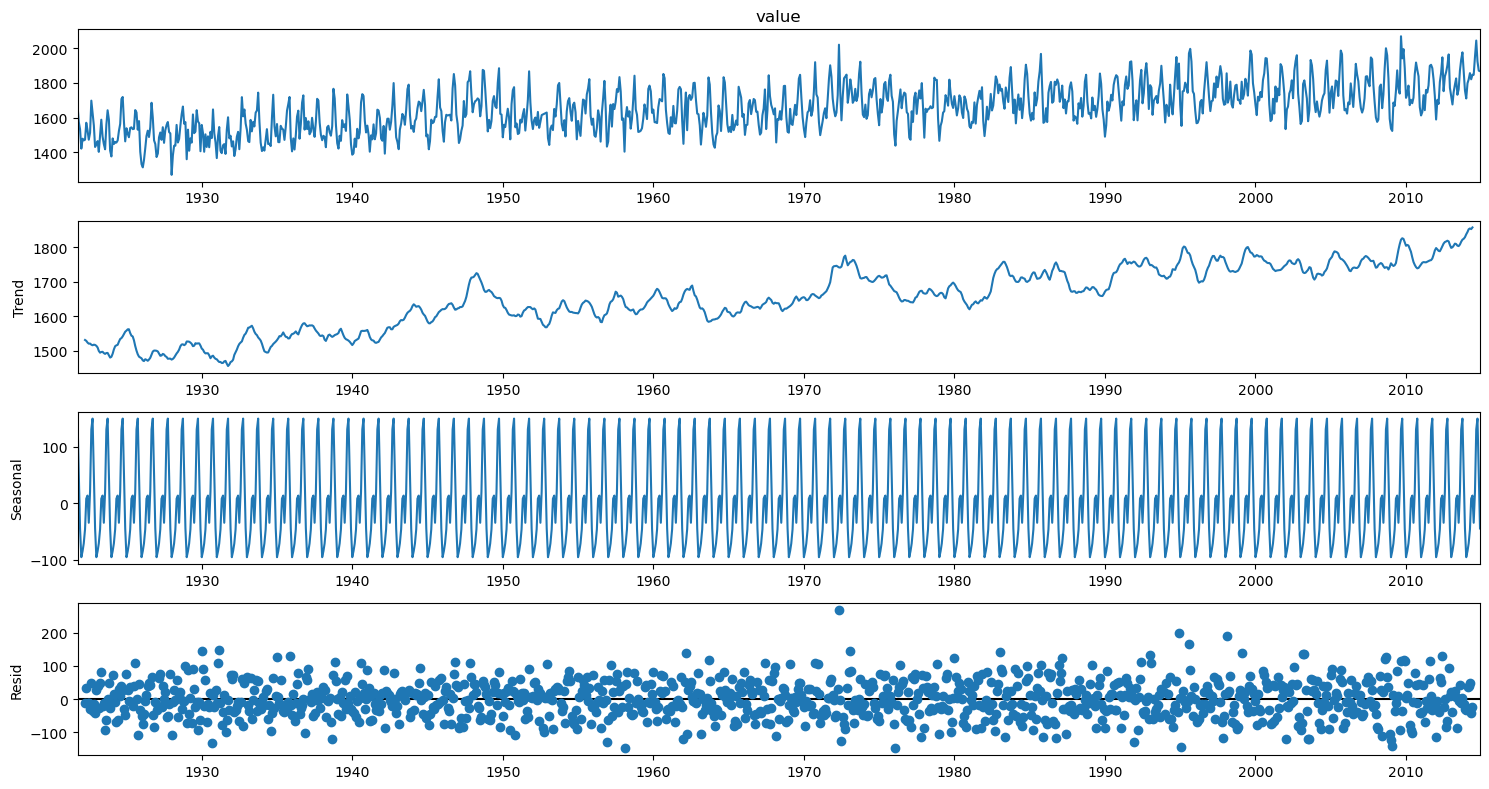

In [10]:
plt.rc("figure", figsize=(15,8))
result = seasonal_decompose(df_plot2['value'], model= 'additive')
result.plot()
plt.show()


In [11]:
# subsetting data from 1995 until 2014
df['year'] = df['time'].dt.year
df_m95 = df[df['year'] > 1994]

df_m95 = df_m95.reset_index()
df_m95.drop(columns=['index', 'year'], inplace=True)

# make a copy as a safety measure for later process
df_try = df_m95.copy()
df_try.tail(2)

,time,sea_surface_height_above_reference_level
7303,2014-12-30 12:00:00+00:00,1789.0
7304,2014-12-31 12:00:00+00:00,1888.0


Total Sea level rise: 74.2 mm


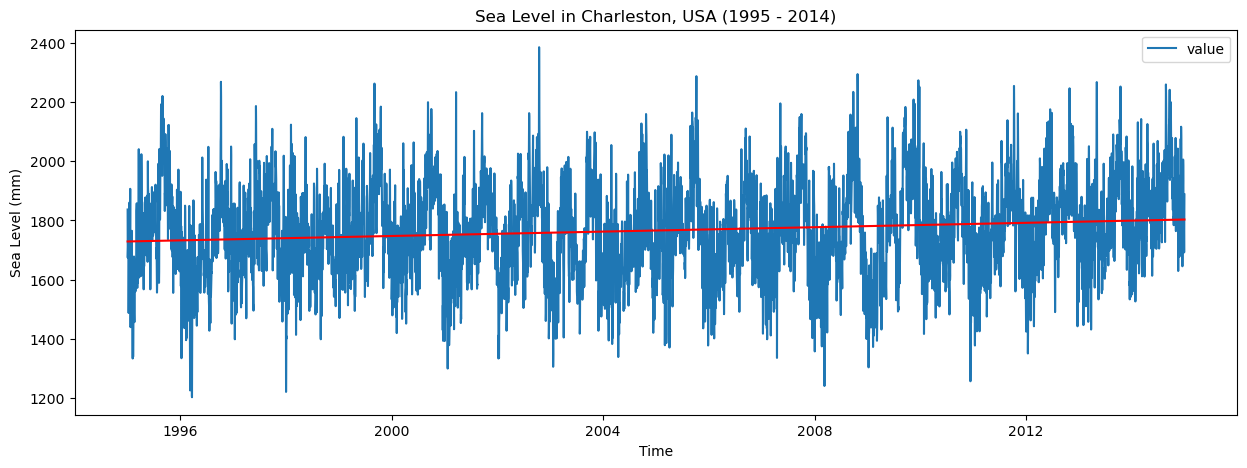

In [12]:
df_try = df_try.set_index(['time'])
df_try = df_try.rename(columns={'sea_surface_height_above_reference_level': 'value'})

# plot the dataset that we're gonna use
plot_dataset_trendline(df_try, title='Sea Level in Charleston, USA (1995 - 2014)')

In [13]:
# generate day, month, and week of year feature
df_features = (df_try
                .assign(day = df_try.index.day)
                .assign(month = df_try.index.month)
                .assign(week_of_year = df_try.index.week)
                .assign(year = df_try.index.year)
              )
def onehot_encode_pd(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1) #.drop(columns=col)
    return df

# one-hot encoding for categorical value from datetime feature
df_features = onehot_encode_pd(df_features, ['day', 'month', 'week_of_year', 'year'])
df_features['year_2015'], df_features['year_2016'] = 0, 0 # for predicting future event purpose

In [14]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

df_features = generate_cyclical_features(df_features, 'day', 31, 1)
df_features = generate_cyclical_features(df_features, 'month', 12, 1)
df_features = generate_cyclical_features(df_features, 'week_of_year', 52, 0)

df_features.tail(3)


,value,year,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,...,year_2013,year_2014,year_2015,year_2016,sin_day,cos_day,sin_month,cos_month,sin_week_of_year,cos_week_of_year
time,,,,,,,,,,,,,,,,,,,,,
2014-12-29 12:00:00+00:00,1692.0,2014,0,0,0,0,0,0,0,0,...,0,1,0,0,-0.571268,0.820763,-0.5,0.866025,0.120537,0.992709
2014-12-30 12:00:00+00:00,1789.0,2014,0,0,0,0,0,0,0,0,...,0,1,0,0,-0.394356,0.918958,-0.5,0.866025,0.120537,0.992709
2014-12-31 12:00:00+00:00,1888.0,2014,0,0,0,0,0,0,0,0,...,0,1,0,0,-0.201299,0.979530,-0.5,0.866025,0.120537,0.992709


In [15]:
from sklearn.model_selection import train_test_split

# function for splitting target dan predictor variable
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

# function for splitting data to train, test, and validation data
def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_features, 'value', 0.2)

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

# function to pick scaler 
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [17]:
scaler = get_scaler('minmax')

# fit and apply scaler to predictor variable
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

# fit and apply scaler to target variable
y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [18]:
scaler = get_scaler('minmax')

# fit and apply scaler to predictor variable
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

# fit and apply scaler to target variable
y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [19]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

# convert data shape to tensor (multi-dimensional matrix containing elements of a single data type)
train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

# wrapping the tensors above as Dataset
train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

# convert data to Pytorch DataLoader (collating data samples into batches)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

In [20]:
import torch.nn as nn

class LSTMModel(nn.Module):
    """LSTMModel class extends nn.Module class and works as a constructor for LSTMs.

       LSTMModel class initiates a LSTM module based on PyTorch's nn.Module class.
       It has only two methods, namely init() and forward(). While the init()
       method initiates the model with the given input parameters, the forward()
       method defines how the forward propagation needs to be calculated.
       Since PyTorch automatically defines back propagation, there is no need
       to define back propagation method.

       --Attributes--
           hidden_dim: int 
               The number of nodes in each layer
           layer_dim: int
               The number of layers in the network
           lstm: nn.LSTM
               The LSTM model constructed with the input parameters.
           fc: nn.Linear
               The fully connected layer to convert the final state of LSTMs to our desired output shape.

    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        """The __init__ method that initiates a LSTM instance.

        --Arguments--
            input_dim: int
                The number of nodes in the input layer
            hidden_dim: int
                The number of nodes in each layer
            layer_dim: int
                The number of layers in the network
            output_dim: int
                The number of nodes in the output layer
            dropout_prob: float
                The probability of nodes being dropped out

        """
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        --Arguments--
            x: torch.Tensor 
                The input tensor of the shape (batch size, sequence length, input_dim)

        --Returns--
            out: torch.Tensor 
                The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [21]:
class Optimization:
    """
    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    --Attributes--
        model: 
            Model class created for the type of RNN
        loss_fn: torch.nn.modules.Loss
            Loss function to calculate the losses
        optimizer: torch.optim.Optimizer 
            Optimizer function to optimize the loss function
        train_losses: list[float]
            The loss values from the training
        val_losses: list[float]
            The loss values from the validation
    """
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """
        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        --Arguments--
            x: torch.Tensor
                Tensor for features to train one step
            y: torch.Tensor
                Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """
        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. Finally, it saves the model in a designated file path.

        --Arguments--
            train_loader: torch.utils.data.DataLoader
                DataLoader that stores training data
            val_loader: torch.utils.data.DataLoader
                DataLoader that stores validation data
            batch_size: int
                Batch size for mini-batch training
            n_epochs: int 
                Number of epochs, i.e., train steps, to train
            n_features: int
                Number of feature columns

        """
        model_path = f'model_lstm'
        
        for epoch in range(1, n_epochs + 1):
            # mini-batch training iteration of training datasets
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
                # update training loss value
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
            
            with torch.no_grad():
                # mini-batch training iteration of validation datasets
                batch_val_losses = []
                validation = []
                validation_values = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                    #
                    validation.append(yhat.to(device).detach().numpy())
                    validation_values.append(y_val.to(device).detach().numpy())
                # update validation loss value
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
            
            # print loss value per epoch period
            if (epoch <= 10) | (epoch % 10 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)
        return validation, validation_values

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """
        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        --Arguments--
            test_loader: torch.utils.data.DataLoader 
                DataLoader that stores test data
            batch_size: int
                Batch size for mini-batch training
            n_features: int
                Number of feature columns

        --Returns--
            predictions: list[float]
                The values predicted by the model
            values: list[float]
                The actual values in the test set.

        """
        # mini-batch testing to evaluate data from test dataset
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                # save model prediction result to list
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def predict(self, future_loader, batch_size=1, n_features=1):
        """
        The method takes DataLoaders for the predicting future dataset, batch size for mini-batch testing,
        and number of features as inputs. 

        --Arguments--
            test_loader: torch.utils.data.DataLoader 
                DataLoader that stores test data
            batch_size: int
                Batch size for mini-batch training
            n_features: int
                Number of feature columns

        --Returns--
            predictions: list[float]
                The values predicted by the model

        """
        # mini-batch testing to predict data from future dataset
        with torch.no_grad():
            predictions = []
            for x_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                self.model.eval()
                yhat = self.model(x_test)
                # save model prediction result to list
                predictions.append(yhat.to(device).detach().numpy())

        return predictions
    
    def plot_losses(self):
        """
        The method plots the calculated loss values for training and validation
        """
        plt.figure(figsize=[8, 5])
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [22]:
# LSTM config
input_dim = len(X_train.columns)
output_dim = 1 
hidden_dim = 64 
layer_dim = 4 
batch_size = batch_size
dropout = 0.05
# training and evaluate config
n_epochs = 30
# weight optimization config
learning_rate = 1e-3
weight_decay = 1e-6

# bundle config in dictionary
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

[1/30] Training loss: 0.0507	 Validation loss: 0.0180
[2/30] Training loss: 0.0141	 Validation loss: 0.0135
[3/30] Training loss: 0.0126	 Validation loss: 0.0137
[4/30] Training loss: 0.0123	 Validation loss: 0.0140
[5/30] Training loss: 0.0118	 Validation loss: 0.0139
[6/30] Training loss: 0.0116	 Validation loss: 0.0142
[7/30] Training loss: 0.0114	 Validation loss: 0.0146
[8/30] Training loss: 0.0113	 Validation loss: 0.0148
[9/30] Training loss: 0.0112	 Validation loss: 0.0150
[10/30] Training loss: 0.0112	 Validation loss: 0.0152
[20/30] Training loss: 0.0114	 Validation loss: 0.0252
[30/30] Training loss: 0.0106	 Validation loss: 0.0160


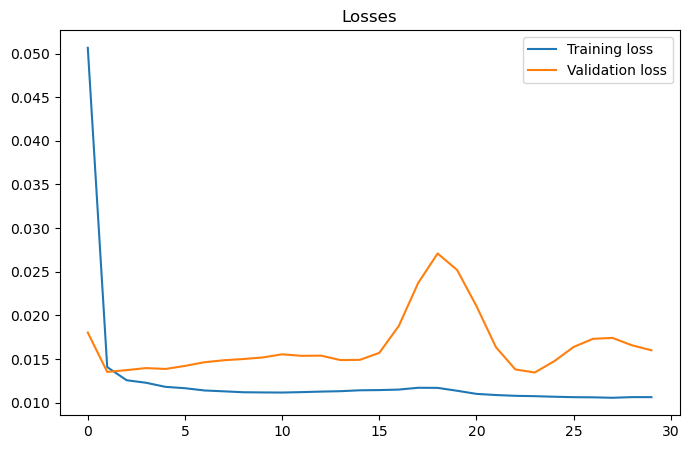

In [23]:
import torch.optim as optim

model = LSTMModel(**model_params)

# set criterion to calculate loss gradient
loss_fn = nn.MSELoss(reduction="mean")
# set model optimizer (process of adjusting model parameters to reduce model error in each training step)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# training model
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
validation, validation_values = opt.train(
    train_loader, 
    val_loader, 
    batch_size=batch_size, 
    n_epochs=n_epochs, 
    n_features=input_dim,
)
opt.plot_losses()

# evaluate model based on model from training dataset
predictions, values = opt.evaluate(
    test_loader,
    batch_size=batch_size,
    n_features=input_dim
)

In [24]:
# inverse the scale from model result
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

# change format of multi-dimensional tensors to one-dimensional vectors (flatten)
def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

In [25]:
df_val = format_predictions(validation, validation_values, X_val, scaler)
df_result = format_predictions(predictions, values, X_test, scaler)
df_result.head()

,value,prediction
time,,
2011-01-01 12:00:00+00:00,1589.000000,1674.293091
2011-01-02 12:00:00+00:00,1478.000000,1692.733032
2011-01-03 12:00:00+00:00,1501.000122,1694.004639
2011-01-04 12:00:00+00:00,1632.000000,1677.478149
2011-01-05 12:00:00+00:00,1608.000122,1674.854492


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error #, mean_absolute_percentage_error

def calculate_metrics(df):
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : np.sqrt(mean_squared_error(df.value, df.prediction)),}
#                       'mape' : mean_absolute_percentage_error(df.value, df.prediction)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
#     print("MAPE Score:                ", result_metrics["mape"])
    
    return result_metrics

result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        111.47792
Root Mean Squared Error:    138.37053


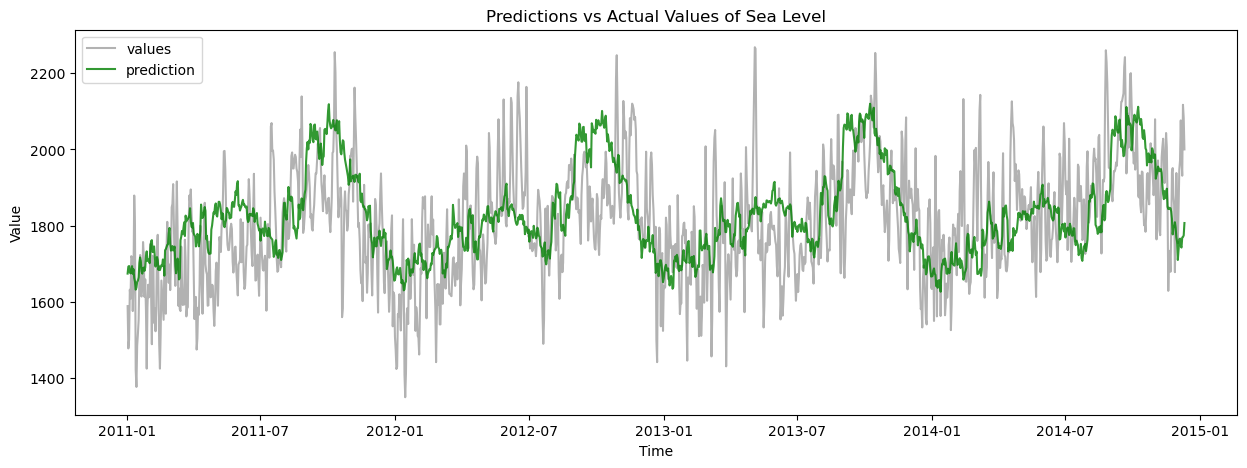

In [27]:
def plot_predictions(df_result):
    plt.figure(figsize=(15,5))
    value = sns.lineplot(x = df_result.index, y=df_result.value, color='k', alpha = 0.3, label = 'values')
    prediction = sns.lineplot(x = df_result.index, y=df_result.prediction, color='g', alpha = 0.8, label = 'prediction')
    
    plt.title("Predictions vs Actual Values of Sea Level")
    plt.xlabel('Time')
    plt.ylabel('Value') 
    
plot_predictions(df_result)

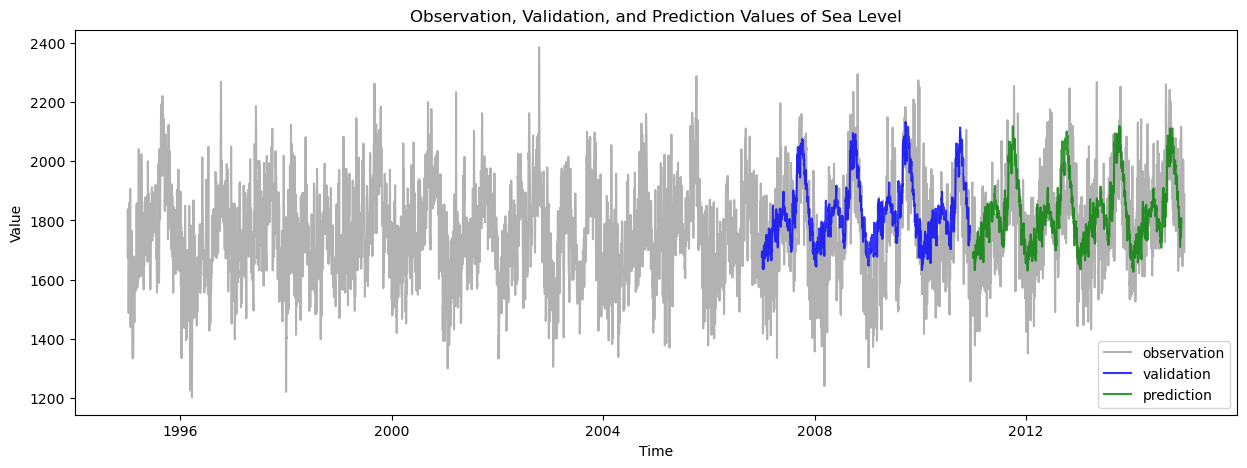

In [28]:
def plot_all(df_result, df_train, df_val):
    plt.figure(figsize=(15,5))
    observation = sns.lineplot(x = df_train.index, y=df_train.value, color='k', alpha = 0.3, label = 'observation')
    validation = sns.lineplot(x = df_val.index, y=df_val.prediction, color='b', alpha = 0.8, label = 'validation')
    prediction = sns.lineplot(x = df_result.index, y=df_result.prediction, color='g', alpha = 0.8, label = 'prediction')
    
    plt.title("Observation, Validation, and Prediction Values of Sea Level")
    plt.xlabel('Time')
    plt.ylabel('Value') 
    
plot_all(df_result, df_features, df_val)

Sea level rise (values) from 2011-2014: 170.51 mm
Sea level rise (prediction) from 2011-2014: 69.27 mm


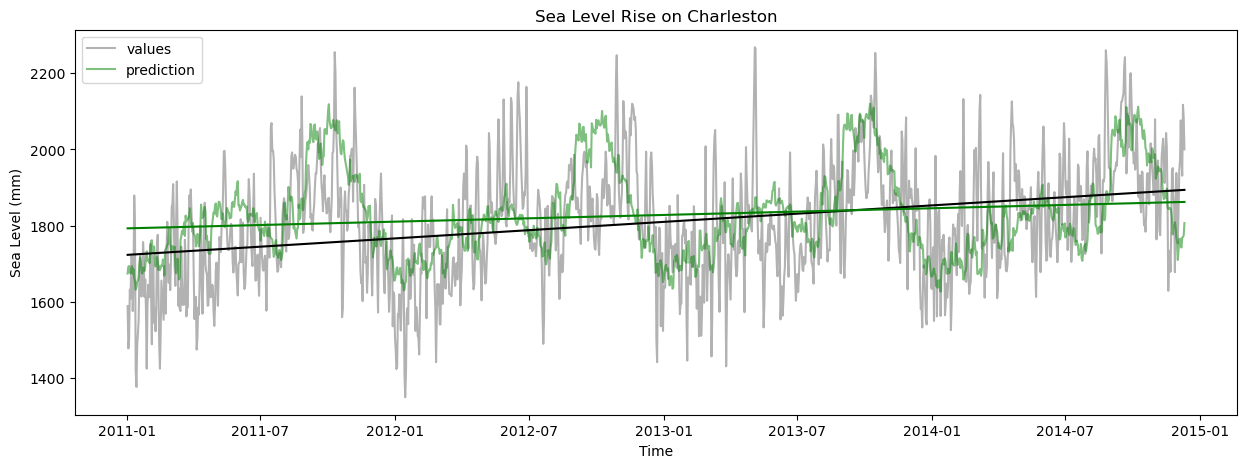

In [29]:
def plot_dataset_trendline_after_model(df, title):
    plt.figure(figsize=(15, 5))
    # plot dataset
    sns.lineplot(x=df.index, y=df.value, color = 'k', alpha = 0.3, label='values')
    sns.lineplot(x=df.index, y=df.prediction, color='g', alpha= 0.5, label='prediction')

    # plot trendline of observation value
    x = range(0, len(df))
    z = np.polyfit(x, y=df.value, deg=1)  
    p = np.poly1d(z)
    plt.plot(df.index, p(x), c="k", ls='-')
    print(f'Sea level rise (values) from 2011-2014: {round(p(len(df)) - p(0), 2)} mm')
    
    # plot trendline of prediction (have to be clean from missing data)
    x = range(0, len(df))
    z = np.polyfit(x, y=df.prediction, deg=1)  
    p = np.poly1d(z)
    plt.plot(df.index, p(x), c="g", ls='-')
    print(f'Sea level rise (prediction) from 2011-2014: {round(p(len(df)) - p(0), 2)} mm')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Sea Level (mm)')
    
plot_dataset_trendline_after_model(df_result, 'Sea Level Rise on Charleston')

In [30]:
def give_year_name(df, start, end, name):
    i = start
    while i <= end:
        df[f'{name}_{i}'] = 0
        i += 1
    
    return df

In [31]:
from datetime import date

sdate = date(2015,1,1)   # define start date
edate = date(2016,12,31)   # define end date

# make a dataframe with range of sdate and edate
df_future = pd.DataFrame(pd.date_range(sdate, edate, freq='d'))
df_future.columns = ['time']
df_future['value'] = 0 # it's just here because the function need it as an input
df_future.set_index('time', inplace=True)

# make features with datetime object
df_future = (df_future
             .assign(day = df_future.index.day)
             .assign(month = df_future.index.month)
             .assign(week_of_year = df_future.index.week)
             .assign(year = df_future.index.year)
            )

# one hot encoding the features
df_future = onehot_encode_pd(df_future, ['day', 'month', 'week_of_year'])
df_future = give_year_name(df_future, 1995, 2014, 'year')
df_future = onehot_encode_pd(df_future, ['year'])

df_future = generate_cyclical_features(df_future, 'day', 31, 1)
df_future = generate_cyclical_features(df_future, 'month', 12, 1)
df_future = generate_cyclical_features(df_future, 'week_of_year', 52, 0)

In [32]:
# split the data that we going to predict
X_fut, y_fut = feature_label_split(df_future, 'value')

#scaling
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_fut_arr = scaler.transform(X_fut)
# X_fut_arr = np.array(X_fut)
y_train_arr = scaler.fit_transform(y_train)
y_fut_arr = scaler.transform(y_fut)

# convert to tensor
X_fut_tens = torch.Tensor(X_fut_arr)
y_fut_tens = torch.Tensor(y_fut_arr)

# convert to Dataset object (pytorch)
future = TensorDataset(X_fut_tens, y_fut_tens)
future_loader = DataLoader(future, batch_size=batch_size, shuffle=False, drop_last=True)

In [33]:
# predict using evaluate function
fut_predictions, fut_values = opt.evaluate(
    future_loader,
    batch_size=batch_size,
    n_features=input_dim
)

# format the prediction result
df_future_predict = format_predictions(fut_predictions, fut_values, X_fut, scaler)

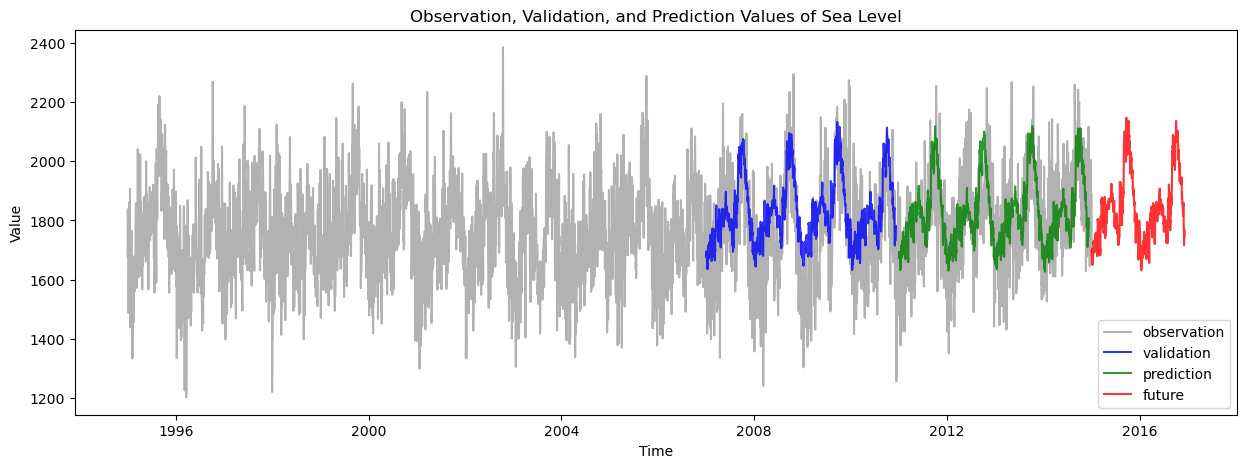

In [34]:
def plot_future(df_result, df_train, df_val, df_future):
    plot_all(df_result, df_train, df_val)
    future = sns.lineplot(x = df_future.index, y=df_future.prediction, color='r', alpha = 0.8, label = 'future')
    
plot_future(df_result, df_features, df_val, df_future_predict)